In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import cvxpy as cp
from scipy.stats import poisson, uniform, expon, pareto, hypergeom
from scipy.optimize import minimize, fsolve, least_squares
import scipy as sc
from tqdm import tqdm
from mdptoolbox import mdp, util
import itertools
from scipy.sparse import csr_matrix, lil_matrix
from matplotlib.patches import Patch
import math
import random
import sympy as sp
from sympy.printing.latex import print_latex

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 16

USD in its core form is a liability on the federal reserve balance sheet. 

In [2]:
total_liabilites = pd.read_csv(
    'total-liabilities.csv', 
    names=['date', 'value'], 
    skiprows=1, 
    parse_dates=['date'])
total_liabilites.head()

,date,value
0,2002-12-18,702053
1,2002-12-25,713850
2,2003-01-01,714234
3,2003-01-08,706601
4,2003-01-15,702678


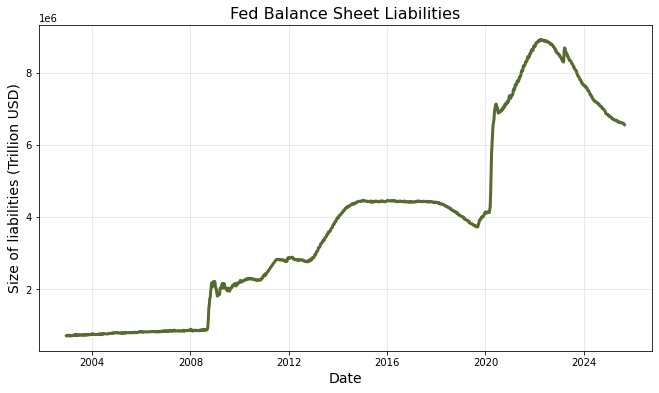

In [3]:
f, ax = plt.subplots(figsize=(11,6))
ax.plot(total_liabilites['date'], total_liabilites['value'], color='darkolivegreen', linewidth=3)

ax.set_ylabel('Size of liabilities (Trillion USD)')
ax.set_xlabel('Date')
ax.set_title('Fed Balance Sheet Liabilities')
ax.grid(alpha=0.3)
plt.show()

In [4]:
tl_latest = total_liabilites[total_liabilites['date'] >= '2023-03-01']

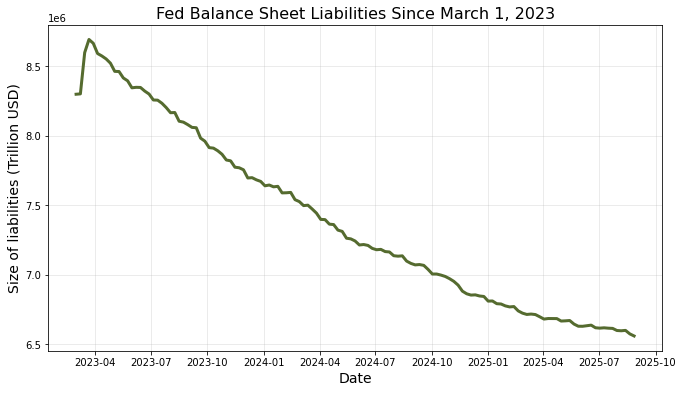

In [5]:
f, ax = plt.subplots(figsize=(11,6))
ax.plot(tl_latest['date'], tl_latest['value'], color='darkolivegreen', linewidth=3)

ax.set_ylabel('Size of liabilities (Trillion USD)')
ax.set_xlabel('Date')
ax.set_title('Fed Balance Sheet Liabilities Since March 1, 2023')
ax.grid(alpha=0.3)
plt.show()

remember, 96% of the fed liabilites is the sum of currency and the fed acct balances, including the treasury balance. let's look at those time series of the same period

In [6]:
currency = pd.read_csv('paper-money.csv', names=['date', 'value'], skiprows=1, parse_dates=['date'])
reserves = pd.read_csv('reserve-balances.csv', names=['date', 'value'], skiprows=1, parse_dates=['date'])
treasury = pd.read_csv('treasury-acct.csv', names=['date', 'value'], skiprows=1, parse_dates=['date'])

In [7]:
currency_latest = currency[currency['date'] >= '2023-03-01']
reserves_latest = reserves[reserves['date'] >= '2023-03-01']
treasury_latest = treasury[treasury['date'] >= '2023-03-01']
treasury_nearest = pd.merge_asof(
    reserves_latest[['date']], treasury_latest, on='date', direction='nearest'
)

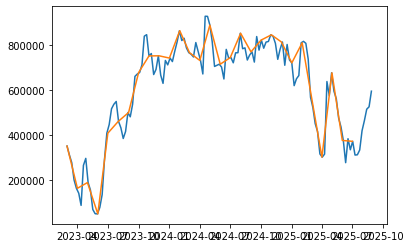

In [11]:
plt.plot(treasury_latest['date'], treasury_latest['value'])
plt.plot(treasury_nearest['date'], treasury_nearest['value'])

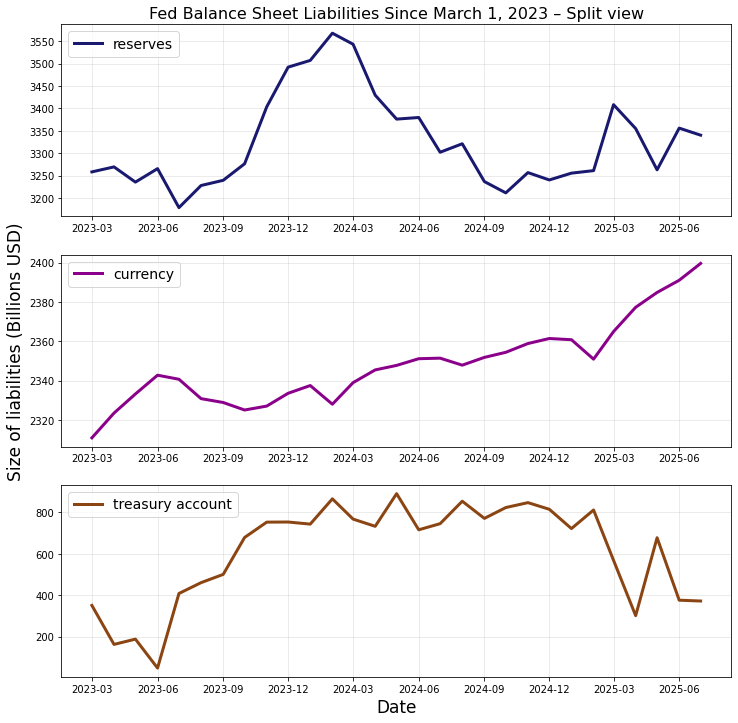

In [59]:
f, axarr = plt.subplots(nrows=3, figsize=(12,12))
axarr[0].plot(reserves_latest['date'], reserves_latest['value'], color='midnightblue', linewidth=3, 
        label='reserves')
axarr[1].plot(currency_latest['date'], currency_latest['value'], color='darkmagenta', linewidth=3, 
        label='currency')
axarr[2].plot(treasury_nearest['date'], treasury_nearest['value']/int(1e3), color='saddlebrown', linewidth=3, 
        label='treasury account')

axarr[2].set_xlabel('Date', size=17)
axarr[1].set_ylabel('Size of liabilities (Billions USD)', size=17)
axarr[0].set_title('Fed Balance Sheet Liabilities Since March 1, 2023 – Split view')

xticks = pd.date_range("2023-03-01", "2025-07-01", freq="3MS")
for ax in axarr:
    ax.legend(loc=2, fontsize=14)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticks.strftime("%Y-%m"))
    ax.grid(alpha=0.3)


# ax.legend()
plt.show()

In [27]:
total = (treasury_nearest['value'].values /int(1e3) 
         + currency_latest['value'].values 
         + reserves_latest['value'].values)

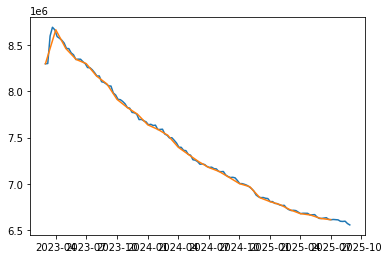

In [44]:
liabilities_nearest = pd.merge_asof(
    reserves_latest[['date']], tl_latest, on='date', direction='nearest'
)

plt.plot(tl_latest['date'], tl_latest['value'])
plt.plot(liabilities_nearest['date'], liabilities_nearest['value'])

In [71]:
total[-1], liabilities_nearest['value'].values[-1], total[-1]/liabilities_nearest['value'].values[-1]*int(1e3)

(6112.07, 6614045, 0.924104689339126)

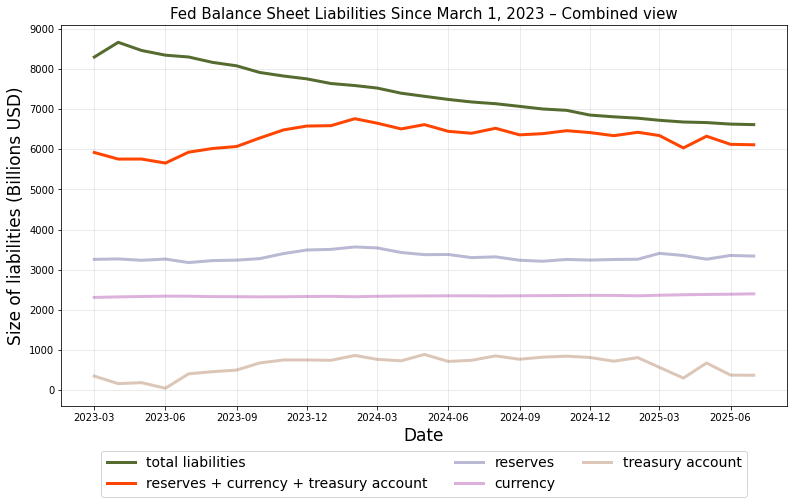

In [74]:
f, ax = plt.subplots(figsize=(13,7))

ax.plot(liabilities_nearest['date'], liabilities_nearest['value']/int(1e3), 
              color='darkolivegreen', linewidth=3, label='total liabilities')
ax.plot(treasury_nearest['date'], total, color='orangered', linewidth=3, 
        label='reserves + currency + treasury account')

ax.plot(reserves_latest['date'], reserves_latest['value'], color='midnightblue', linewidth=3, 
        label='reserves', alpha=0.3)
ax.plot(currency_latest['date'], currency_latest['value'], color='darkmagenta', linewidth=3, 
        label='currency', alpha=0.3)
ax.plot(treasury_nearest['date'], treasury_nearest['value']/int(1e3), color='saddlebrown', linewidth=3, 
        label='treasury account', alpha=0.3)



ax.set_xlabel('Date', size=17)
ax.set_ylabel('Size of liabilities (Billions USD)', size=17)

xticks = pd.date_range("2023-03-01", "2025-07-01", freq="3MS")
ax.set_xticks(xticks)
ax.set_xticklabels(xticks.strftime("%Y-%m"))

ax.legend(
    loc="upper center",      # place relative to the bbox_to_anchor
    bbox_to_anchor=(0.5, -0.1),  # center it below the x-axis
    ncol=3,                  # split into 2 columns
    fontsize=14,
)
ax.set_title('Fed Balance Sheet Liabilities Since March 1, 2023 – Combined view', size=15)
ax.grid(alpha=0.3)
ax.set_yticks(np.arange(0, 9001, 1000))

plt.show()

what gives? we are missing the ON RRPs, which were a huge part of the feds balance sheet during that time period

In [76]:
rrepos = pd.read_csv('reverse-repos.csv', names=['date', 'value'], skiprows=1, parse_dates=['date'])
rrepos_latest = rrepos[rrepos['date'] >= '2023-03-01']

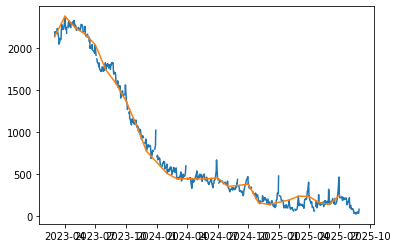

In [79]:
rrepos_nearest = pd.merge_asof(
    reserves_latest[['date']], rrepos_latest, on='date', direction='nearest'
).interpolate(method='linear', limit_direction='both')

plt.plot(rrepos_latest['date'], rrepos_latest['value'])
plt.plot(rrepos_nearest['date'], rrepos_nearest['value'])

In [84]:
total_rr = (treasury_nearest['value'].values /int(1e3) 
         + currency_latest['value'].values 
         + reserves_latest['value'].values
         + rrepos_nearest['value'].values)

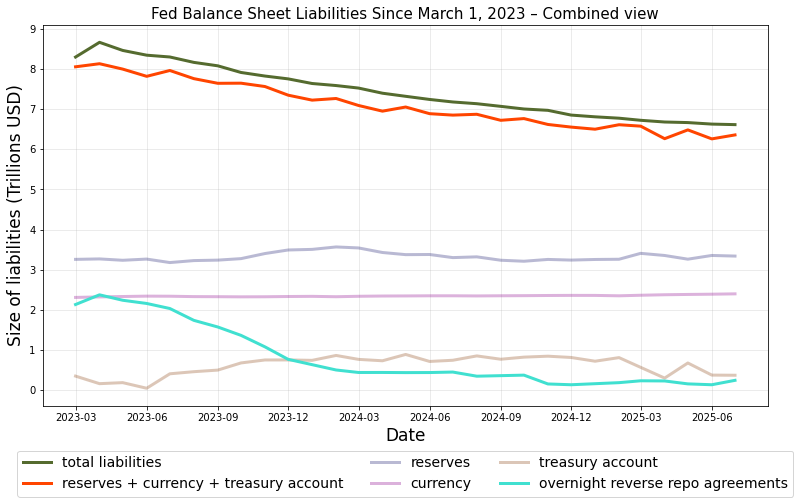

In [88]:
f, ax = plt.subplots(figsize=(13,7))

ax.plot(liabilities_nearest['date'], liabilities_nearest['value']/int(1e3), 
              color='darkolivegreen', linewidth=3, label='total liabilities')
ax.plot(treasury_nearest['date'], total_rr, color='orangered', linewidth=3, 
        label='reserves + currency + treasury account')

ax.plot(reserves_latest['date'], reserves_latest['value'], color='midnightblue', linewidth=3, 
        label='reserves', alpha=0.3)
ax.plot(currency_latest['date'], currency_latest['value'], color='darkmagenta', linewidth=3, 
        label='currency', alpha=0.3)
ax.plot(treasury_nearest['date'], treasury_nearest['value']/int(1e3), color='saddlebrown', linewidth=3, 
        label='treasury account', alpha=0.3)
ax.plot(rrepos_nearest['date'], rrepos_nearest['value'], color='turquoise', linewidth=3, 
        label='overnight reverse repo agreements', alpha=1)


ax.set_xlabel('Date', size=17)
ax.set_ylabel('Size of liabilities (Trillions USD)', size=17)

xticks = pd.date_range("2023-03-01", "2025-07-01", freq="3MS")
ax.set_xticks(xticks)
ax.set_xticklabels(xticks.strftime("%Y-%m"))

ax.legend(
    loc="upper center",      # place relative to the bbox_to_anchor
    bbox_to_anchor=(0.5, -0.1),  # center it below the x-axis
    ncol=3,                  # split into 2 columns
    fontsize=14,
)
ax.set_title('Fed Balance Sheet Liabilities Since March 1, 2023 – Combined view', size=15)
ax.grid(alpha=0.3)
ax.set_yticks(np.arange(0, 9001, 1000))
ax.set_yticklabels(np.arange(0, 10))

plt.show()

this is a bit of a red herring though! just because money is leaving the ON RRP facility, doesn't mean it is flowing off the balance sheet. 
here is how it moves (93% of it is from money market funds) 
 
 ON RRP
 - $100
 
 Treasury account
 - $100
 
 - MMF pulls $1 from the ON RRP facility
 - MMF buys  $1 of Tbills 
 
 ON RRP
 - $99
 
 Treasury account
 - $101
 
 on net, the balance sheet is still $200, so no decrease in the liabilities happened.

to square this circle, we actually need to go to the asset side of the fed's balance sheet, which is actually a lot simpler. 

In [90]:
assets = pd.read_csv('total-assets.csv', names=['date', 'value'], skiprows=1, parse_dates=['date'])
treasuries = pd.read_csv('treasuries.csv', names=['date', 'value'], skiprows=1, parse_dates=['date'])
mbs = pd.read_csv('mbs.csv', names=['date', 'value'], skiprows=1, parse_dates=['date'])

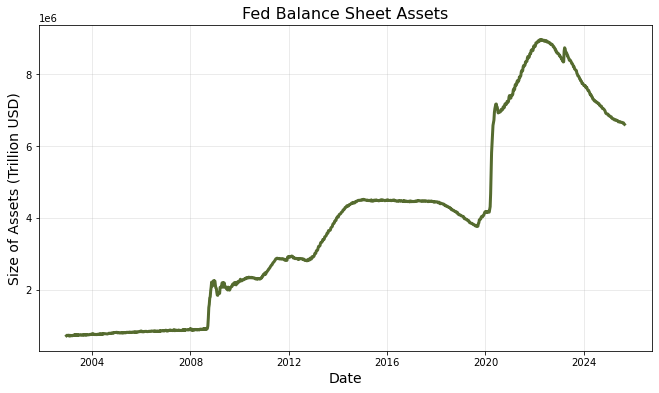

In [114]:
f, ax = plt.subplots(figsize=(11,6))
ax.plot(assets['date'], assets['value'], color='darkolivegreen', linewidth=3)

ax.set_ylabel('Size of Assets (Trillion USD)')
ax.set_xlabel('Date')
ax.set_title('Fed Balance Sheet Assets')
ax.grid(alpha=0.3)
plt.show()

In [95]:
assets_latest = assets[assets['date'] >= '2023-03-01']
treasu_latest = treasuries[treasuries['date'] >= '2023-03-01']
mbs_latest    = mbs[mbs['date'] >= '2023-03-01']

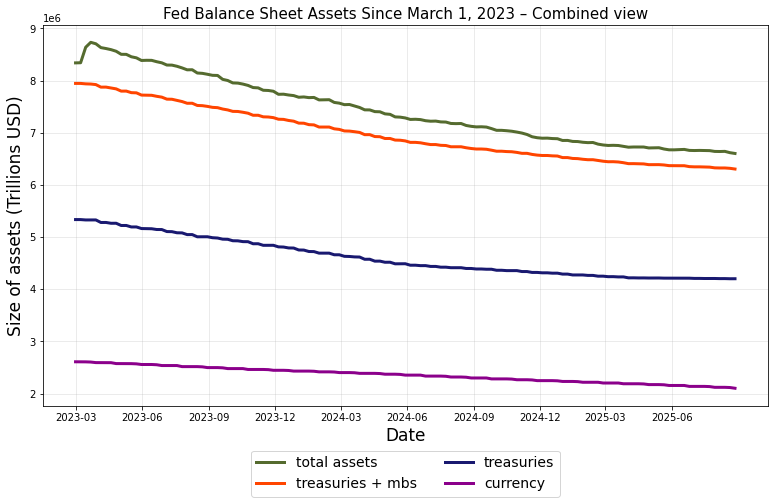

In [111]:
f, ax = plt.subplots(figsize=(13,7))

ax.plot(assets_latest['date'], assets_latest['value'], 
              color='darkolivegreen', linewidth=3, label='total assets')
ax.plot(mbs_latest['date'], mbs_latest['value'].values + treasu_latest['value'].values, 
        color='orangered', linewidth=3, label='treasuries + mbs')

ax.plot(treasu_latest['date'], treasu_latest['value'], color='midnightblue', linewidth=3, 
        label='treasuries')
ax.plot(mbs_latest['date'], mbs_latest['value'], color='darkmagenta', linewidth=3, 
        label='currency')


ax.set_xlabel('Date', size=17)
ax.set_ylabel('Size of assets (Trillions USD)', size=17)

xticks = pd.date_range("2023-03-01", "2025-07-01", freq="3MS")
ax.set_xticks(xticks)
ax.set_xticklabels(xticks.strftime("%Y-%m"))

ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=14)
ax.set_title('Fed Balance Sheet Assets Since March 1, 2023 – Combined view', size=15)
ax.grid(alpha=0.3)

plt.show()

so you just let treasuries mature and don't reinvest morgate backed securities payments. so this is how it plays out


|| FED assets | Treasury Account | 
|-|-|-|
|Before | \$100 | \$100 |
|At maturity | -\$1 | -\$1 |
|After | \$99 | \$99 |


The treasury had to repay the principle, and they do so from the treasury general account. So now both the asset and liability side of the fed balance sheet have decreased by \$1.

But again, this is kind of weird because it looks like the ON RRP facility declining is the cause, but really that pool of capital is just absorbing the *decrease* in the asset side of the balance sheet. What is really happening is the ON RRP capital is just being circulated into treasuries and refilling the treasury general account. 

| | Treasury Account | ON RRP | 
|-|-|-|
| | \$100 | \$100 |
|At maturity | -\$1 |  | 
| | \$99 | \$100 | 
|New treasuries |  +\$1 | -\$1 |
| | \$100 | \$99 | 
|At maturity | -\$1 |  | 
| | \$99 | \$100 | 
|New treasuries |  +\$1 | -\$1 |
| | \$100 | \$98 | 
